In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

In [2]:
Pixels = 256 # Cantidad de Píxeles del Detector.
N_Dopple = 2 # El archivo .raw genera dos imágenes, este número indica eso para promediarlas.
path_raw = "C:\\Users\\Thomas\\XPCi_Project_Code\\Image_Analysis\\RAWs\\" # Directorio donde están los Raw.
path_txt = "C:\\Users\\Thomas\\XPCi_Project_Code\\Image_Analysis\\Txts\\" # Directorio donde se ponen los Txt.
Step = "0" # Dato de geometry_config.in

In [7]:
name = "Some5" # Acá se coloca el nombre del archivo concreto que se quiera analizar.
archive = path_raw + name + ".raw" 

In [8]:
"""
/// Generación de las imágenes a partir de los archivos .raw.
"""

def Matrix_Creator(Raw, Pixels):
    """
    Esta función genera una lista con un par de matrices que representan las dos imágenes que surgen al
    analizar el archivo .raw.
    """
    image_pair = []
    for k in range(0, len(Raw), Pixels*Pixels):
        blank = np.zeros((Pixels, Pixels))
        for i in range(Pixels):
            for j in range(Pixels):
                blank[i, j] = Raw[j + Pixels*i + k]
        image_pair.append(blank)
    return image_pair

def Data_Import(path, name, Pixels):
    """
    Esta función se encarga de tomar la información de la ubicación de la carpeta con los archivos .raw
    y crear las matrices de números asociadas a cada una de las tomas de datos.
    
    Inputs:
        path: Directorio de la carpeta donde están los .raw.
        Pixels: Cantidad de píxeles de la matriz del detector.
        NRaw: Cantidad de imágenes .raw a analizar.
    
    Output:
        data: Lista con los pares de matrices de intensidad de cada .raw.
    """
    
    data = []
    Raw = np.fromfile(path + "{}.raw".format(name), dtype='float32')
    matrix = Matrix_Creator(Raw, Pixels)
    data.append(matrix)
    
    try:
        Raw = np.fromfile(path + "{}_FF.raw".format(name), dtype='float32')
        matrix = Matrix_Creator(Raw, Pixels)
        data.append(matrix)
    except FileNotFoundError:
        None
        
    return data

def Image_Generator(data):
    """
    Esta función genera una lista con las matrices asociadas a cada imágen tomada. Se hace promediando
    las dos matrices de cada .raw para tener la intensidad media.
    
    Inputs:
        data: Lista con cada par de matrices asociado a los .raw que se analizaron.
        N_Dopple: Cantidad de imágenes por archivo .raw (no sabemos si varía).
    
    Output:
        images: Lista con las matrices asociadas a cada imagen analizada.
    """
    images = [] 
    for i in range(0, 2):
        try:
            mean = (data[i][0] + data[i][1])/2
            images.append(mean)
        except IndexError:
            None
    return images

"""
/// Creación de los histogramas de comparación entre píxeles pares e impares.
"""

def Intensity_Mean(image, Pixels):
    intensity = np.zeros(Pixels)
    for i in range(0, Pixels):
        intensity += image[i, 0:Pixels]
    mean = intensity/np.max(intensity)
    return mean


def Aver(name,X1,X2,Step):
    P=np.copy(name)
    for i in range(len(P)):
        P[i,X1:X2]=(1/2)*(P[i,X1-Step:X2-Step]+P[i,X1+Step:X2+Step])
    return P

In [9]:
brute_material = Data_Import(path_raw, name, Pixels)
images = Image_Generator(brute_material)
np.savetxt(path_txt + name + ".txt", images[0])
try: 
    np.savetxt(path_txt + name + "_FF.txt", images[1])
except IndexError:
        None

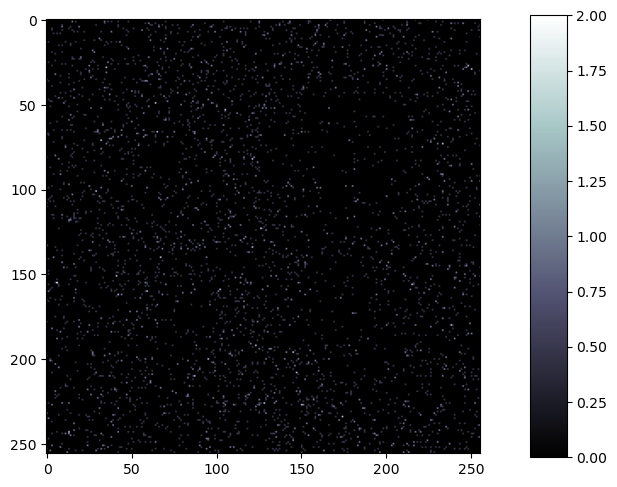

In [10]:
k = 0
fig, ax = plt.subplots(figsize=(7, 7))
map_ = ax.imshow(images[k], cmap = "bone")
fig.colorbar(map_, ax =ax , location='right', anchor=(0.5, 0.5), shrink=0.82, aspect=12)

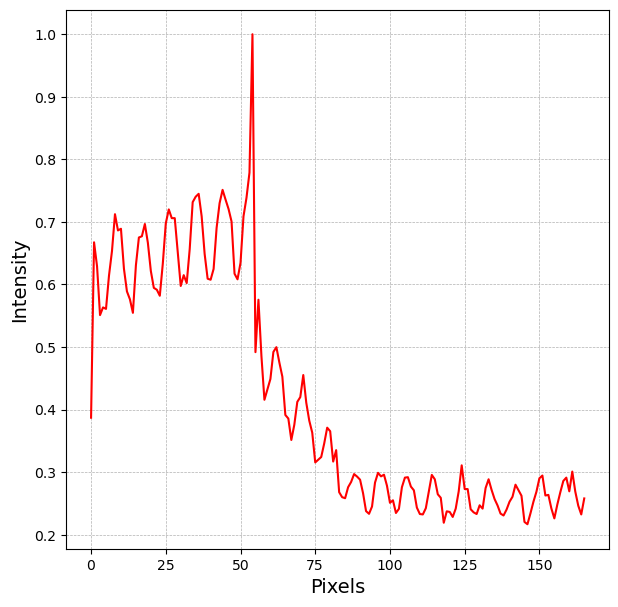

In [14]:
fig, ax = plt.subplots(figsize=(7, 7))
intensities = Intensity_Mean(images[k], Pixels - 90)
ax.plot(intensities, '-', color="red")
ax.set_xlabel("Pixels", fontsize = 14)
ax.set_ylabel("Intensity", fontsize = 14)
ax.grid(linestyle = '--', linewidth = 0.5)

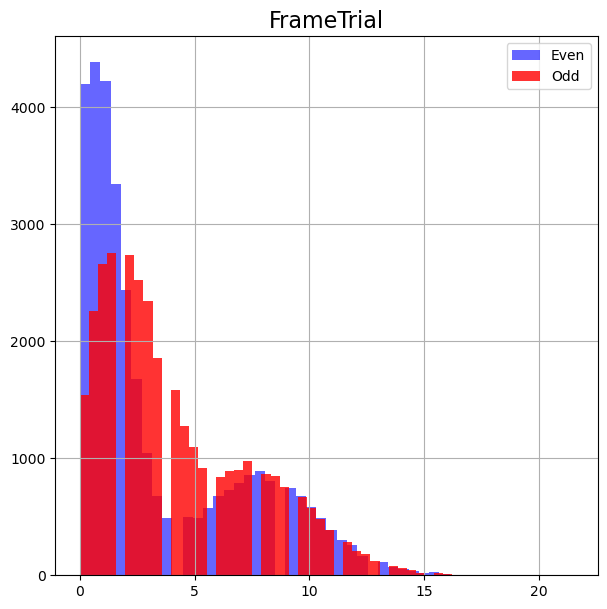

In [15]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.grid(True)


even_pixels = images[k][:,::2]
odd_pixels = images[k][:,1::2]
even_ = np.ravel(even_pixels)
odd_ = np.ravel(odd_pixels)

bin_size = 48
GNMe =ax.hist(even_, bins = bin_size, color="blue", label="Even", alpha=0.6)
GNMo =ax.hist(odd_, bins = bin_size, color="red", label="Odd", alpha=0.8)
ax.set_title("{}".format(name), fontsize=16)
ax.legend()

In [19]:
try:
    Frame = np.loadtxt(path_txt + "{}.txt".format(name))  # Carga las imágenes tomadas.
    FrameFF = np.loadtxt(path_txt + "{}_FF.txt".format(name))  # Carga la imagen del Flat Field.
except Exception as e:
    print(f"Error al cargar los archivos: {e}")
    sys.exit()

# Realizar la división evitando división por cero
N_Frame = np.divide(Frame, FrameFF, out = np.zeros_like(Frame), where = FrameFF != 0)
np.savetxt(path_txt + "Norm\\{}.txt".format(name), N_Frame, fmt = "%.6f")  

In [21]:
image_norm = np.genfromtxt(path_txt + "Norm\\{}.txt".format(name))

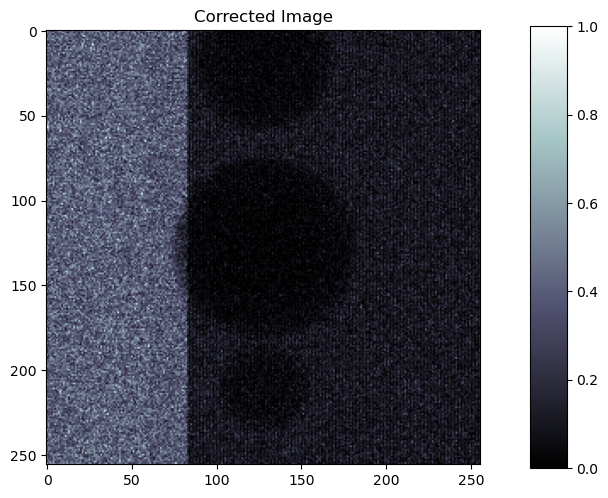

In [23]:
fig, ax = plt.subplots(figsize = (7, 7))
ax.set_title("Corrected Image")
im = ax.imshow(image_norm/np.max(image_norm), cmap="bone")
fig.colorbar(im, ax = ax, location = 'right', anchor = (0.5, 0.5), shrink = 0.82, aspect = 12)

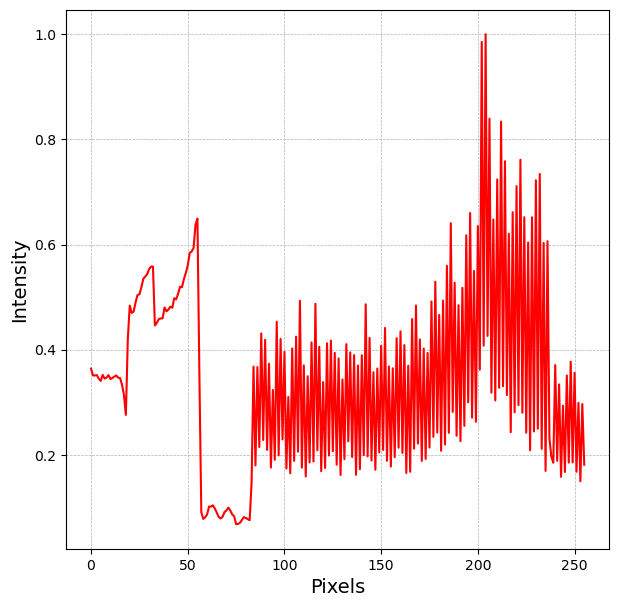

In [77]:
fig, ax = plt.subplots(figsize=(7, 7))
intensities = Intensity_Mean(image_norm, Pixels)
ax.plot(intensities, '-', color="red")
ax.set_xlabel("Pixels", fontsize = 14)
ax.set_ylabel("Intensity", fontsize = 14)
ax.grid(linestyle = '--', linewidth = 0.5)